In [11]:
# 데이터
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import mode

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 모델
import torch
import torch.nn as nn
import torch.nn.functional as F

# 학습
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit

#평가
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Data Load

In [12]:
def data_load():
  df_list = []

  for i in range(0, 10):
      path = f"C:/Users/c/Desktop/ML programming/data/MHEALTHDATASET/mHealth_subject{i+1}.log"
      df = pd.read_csv(path, sep='\t', header=None)
      df['subject'] = i+1
      df.rename(columns={df.columns[23]: 'activity'}, inplace=True)
      # activit 0번 : 0 for the null class 삭제
      df = df[df['activity'] != 0]
      df['activity'] = df['activity'] - 1
      df_list.append(df)

  df_all = pd.concat(df_list, ignore_index=True)
  return df_all

In [13]:
df = data_load()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,activity,subject
0,-9.7788,0.55690,1.19750,0.008373,-0.033490,2.6493,-9.4517,0.37683,-0.20965,-0.88931,...,-9.0618,1.8177,-0.058824,-0.93429,-0.34483,0.355370,-0.37003,-0.35020,0,1
1,-9.7733,0.27880,0.73036,-0.025118,-0.025118,2.4157,-9.5306,0.40179,-0.20965,-0.88931,...,-9.2048,1.5189,-0.058824,-0.93429,-0.34483,0.719910,0.17803,0.37363,0,1
2,-9.8609,0.11561,0.79988,0.025118,0.016745,2.3865,-9.5991,0.48141,-0.20037,-0.86867,...,-9.1945,1.5507,-0.058824,-0.93429,-0.34483,0.355370,-0.37003,-0.35020,0,1
3,-9.7409,0.17652,0.88957,0.180010,0.129770,2.3758,-9.5997,0.42919,-0.20037,-0.86867,...,-9.1746,1.5413,-0.078431,-0.93429,-0.34052,0.357180,-0.18858,-0.35198,0,1
4,-9.7821,0.21637,0.90368,0.092098,0.046049,2.3239,-9.5406,0.40038,-0.20037,-0.86867,...,-9.2039,1.6127,-0.078431,-0.93429,-0.34052,-0.001887,-0.18867,-0.72017,0,1


In [14]:
df.shape

(343195, 25)

## EDA

C:\Users\c\AppData\Local\Temp\ipykernel_23112\2537035384.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='viridis')


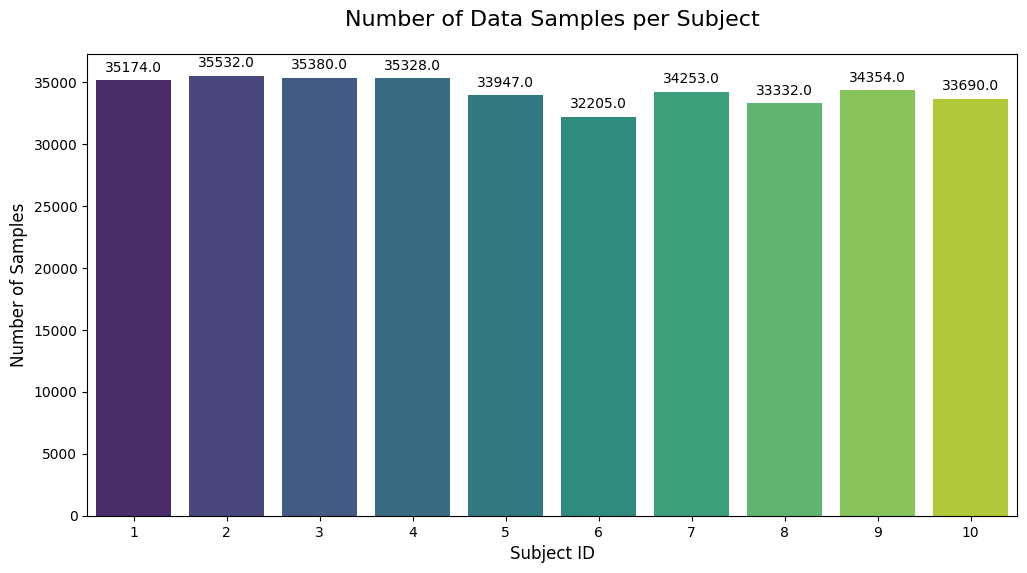

In [15]:
subject_counts = df['subject'].value_counts().sort_index()

plt.figure(figsize=(12, 6))

ax = sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='viridis')

plt.title('Number of Data Samples per Subject', fontsize=16, pad=20)
plt.xlabel('Subject ID', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

C:\Users\c\AppData\Local\Temp\ipykernel_23112\1215715953.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='viridis')


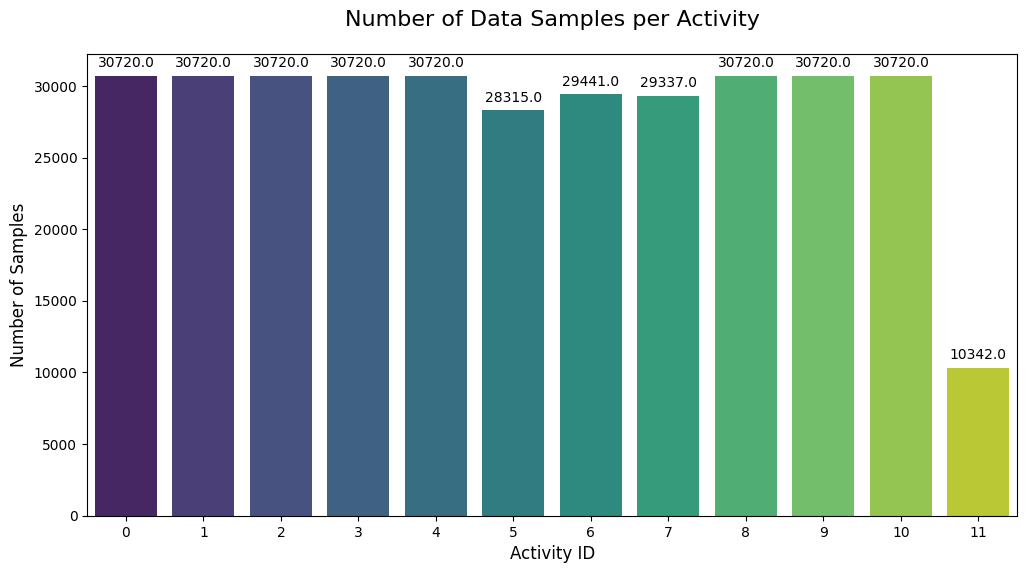

In [16]:
subject_counts = df['activity'].value_counts().sort_index()

plt.figure(figsize=(12, 6))

ax = sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='viridis')

plt.title('Number of Data Samples per Activity', fontsize=16, pad=20)
plt.xlabel('Activity ID', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

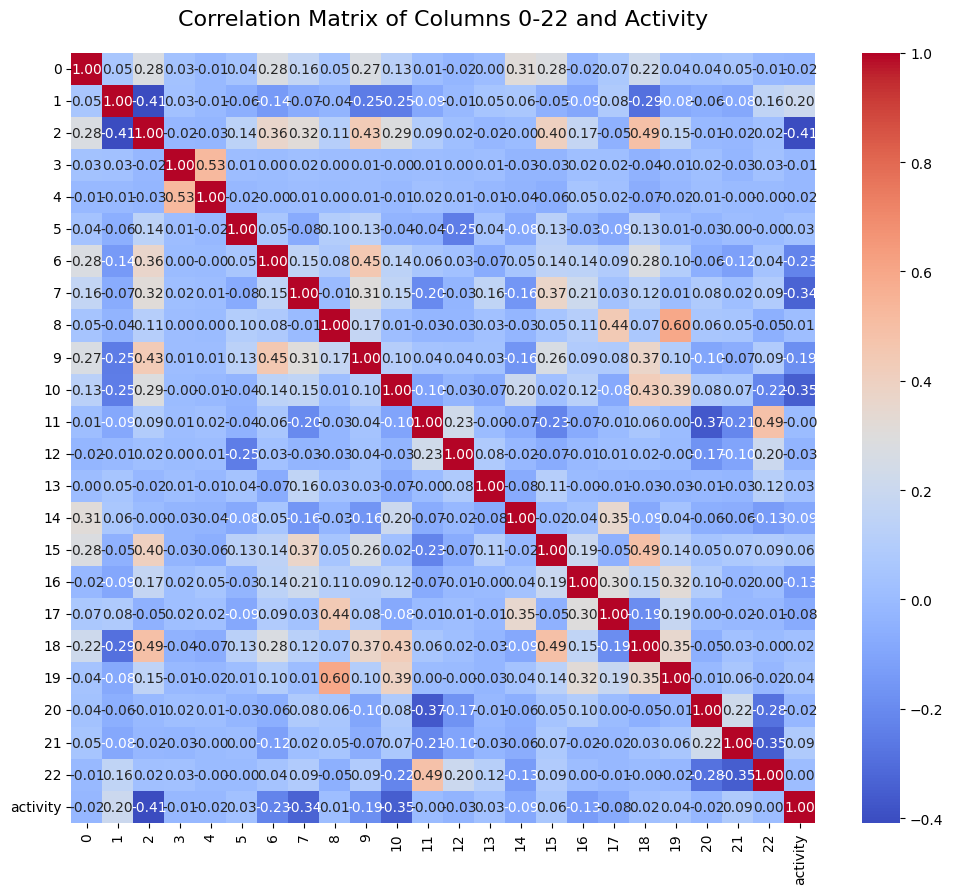

In [17]:
# Calculate the correlation matrix between columns 0-22 and 'activity'
correlation_matrix = df.loc[:, list(range(23)) + ['activity']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Columns 0-22 and Activity', fontsize=16, pad=20)
plt.show()

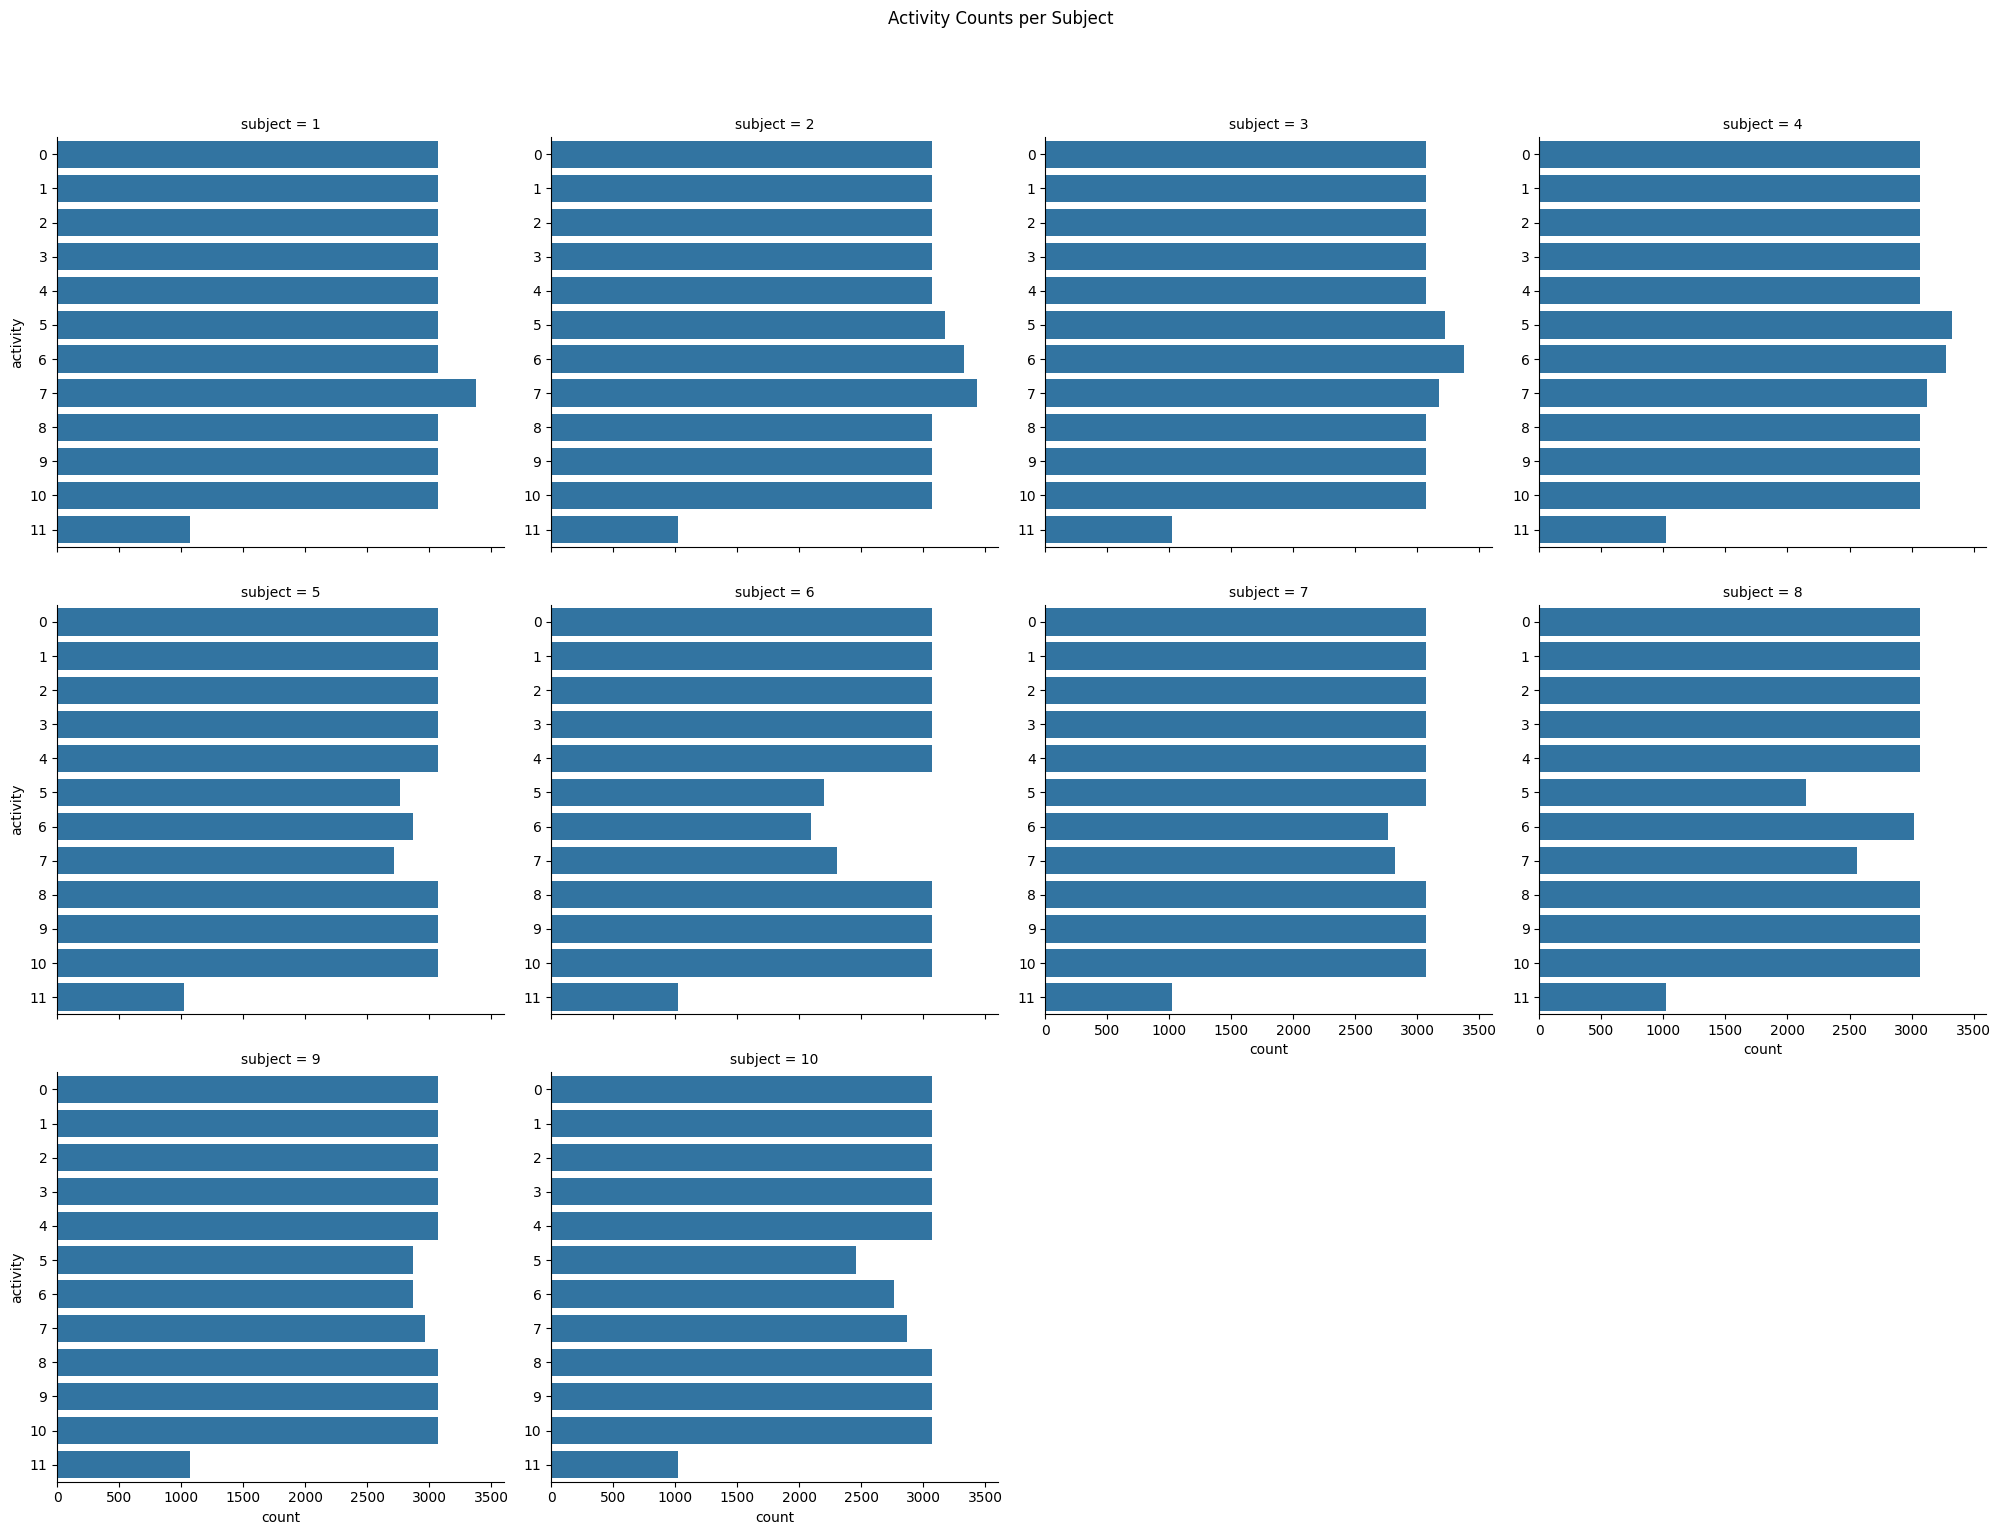

In [18]:
g = sns.catplot(data=df, y='activity', col='subject', kind='count',
                height=5, aspect=1, col_wrap=4, sharey=False)

g.fig.suptitle('Activity Counts per Subject', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Preprocessing

In [19]:
class TimeSeriesDataset(Dataset):
    def __init__(self, features_data, labels_data, frame_size, hop_size):
        """
        초기화 메서드.
        - features_data: 피처 데이터 (Pandas DataFrame 또는 NumPy ndarray)
        - labels_data: 라벨 데이터 (Pandas Series 또는 NumPy ndarray)
        """
        # 입력 데이터가 Pandas 객체이면 .values로 NumPy 배열을 추출하고,
        # 이미 NumPy 배열이면 그대로 사용합니다.
        self.features = features_data.values if hasattr(features_data, 'values') else features_data
        self.labels = labels_data.values if hasattr(labels_data, 'values') else labels_data

        self.frame_size = frame_size
        self.hop_size = hop_size

        self.num_frames = (len(self.features) - frame_size) // hop_size + 1

    def __len__(self):
        return self.num_frames

    def __getitem__(self, idx):
        start_idx = idx * self.hop_size
        end_idx = start_idx + self.frame_size

        frame = self.features[start_idx:end_idx]
    
        label_window = self.labels[start_idx:end_idx]
        label = mode(label_window)[0]

        """
        center_idx = start_idx + self.frame_size // 2
        label = self.labels[center_idx] 
        """

        frame_tensor = torch.tensor(frame, dtype=torch.float32).permute(1, 0) 
        label_tensor = torch.tensor(label, dtype=torch.long)

        return frame_tensor, label_tensor

## Defining Model

In [60]:
# --- 데이터 및 슬라이딩 윈도우 ---
FRAME_SIZE = 128
HOP_SIZE = 64

# --- 학습 파라미터 ---
BATCH_SIZE = 64
EPOCHS = 200
LEARNING_RATE = 0.0001
PATIENCE = 20
N_SPLITS = 5

# --- 모델 아키텍처 파라미터 ---
INPUT_CHANNELS = 23      # CNN에 입력되는 채널 수 (피처 개수)
NUM_CLASSES = 12
CNN_OUTPUT_CHANNELS = 32
LSTM_HIDDEN_SIZE = 32
LSTM_NUM_LAYERS = 1
LSTM_DROPOUT = 0.5
BIDIRECTIONAL = True

# --- 옵티마이저 파라미터 ---
WEIGHT_DECAY = 0.001

In [61]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_channels, num_classes, cnn_out_channels, 
                 lstm_hidden, lstm_layers, lstm_dropout, bidirectional):
        super(CNN_LSTM, self).__init__()
        
        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers
        self.bidirectional = bidirectional

        # --- CNN Feature Extractor ---
        # 성능이 검증된 CNN 모델의 Conv Block들을 활용
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=5, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, cnn_out_channels, kernel_size=3, padding=2),
            nn.BatchNorm1d(cnn_out_channels),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        # --- LSTM Pattern Recognizer ---
        self.lstm = nn.LSTM(
            input_size=cnn_out_channels,     # CNN의 출력 채널이 LSTM의 입력 피처가 됨
            hidden_size=lstm_hidden, 
            num_layers=lstm_layers, 
            batch_first=True,                # (Batch, Seq, Feature) Shape을 따름
            dropout=lstm_dropout,
            bidirectional=bidirectional
        )
        
        # --- Classifier ---
        # 양방향인 경우 hidden_size에 2를 곱해줌
        fc_input_size = lstm_hidden * 2 if bidirectional else lstm_hidden
        self.fc = nn.Linear(fc_input_size, num_classes)

    def forward(self, x):
        # x의 초기 Shape: (Batch, Channels, Seq_Length) e.g., (64, 23, 128)
        
        # 1. CNN을 통과시켜 특징 추출
        x = self.cnn(x) 
        # CNN 통과 후 Shape: (Batch, cnn_out_channels, New_Seq_Length) e.g., (64, 128, 32)
        
        # 2. LSTM 입력을 위해 차원 순서 변경 (가장 중요!)
        # (Batch, Channels, Seq) -> (Batch, Seq, Channels)
        x = x.permute(0, 2, 1)
        
        # 3. LSTM 순전파
        # 양방향인 경우 num_directions는 2
        num_directions = 2 if self.bidirectional else 1
        h0 = torch.zeros(self.lstm_layers * num_directions, x.size(0), self.lstm_hidden).to(x.device)
        c0 = torch.zeros(self.lstm_layers * num_directions, x.size(0), self.lstm_hidden).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        # 4. 마지막 시점의 출력으로 분류
        # out[:, -1, :]는 마지막 시점의 정방향 및 역방향 hidden state를 모두 포함
        out = self.fc(out[:, -1, :])
        
        return out

## Training

In [62]:
class EarlyStopping:
    # __init__ 등 다른 메소드는 동일...
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        
    # *** 카운터 리셋 메소드 추가 ***
    def reset_counter(self):
        """Resets the early stopping counter."""
        self.counter = 0
        if self.verbose:
            print("EarlyStopping counter has been reset.")

In [63]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

In [64]:
def evaluate(model, test_loader, device, criterion):
    model.eval()
    test_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_loss = test_loss / len(test_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    
    # accuracy와 함께 preds와 labels 리스트를 반환
    return avg_loss, accuracy, all_preds, all_labels

In [29]:
# ===============================================================
# 1. 하이퍼파라미터 탐색 공간(Search Space) 정의
# ===============================================================
param_dist = {
    'LEARNING_RATE': [1e-3, 5e-4, 1e-4, 5e-5],
    'WEIGHT_DECAY': [1e-3, 1e-4, 1e-5],
    'LSTM_HIDDEN_SIZE': [64, 128, 256],
    'LSTM_NUM_LAYERS': [1, 2],
    'LSTM_DROPOUT': [0.3, 0.4, 0.5, 0.6]
}

# ===============================================================
# 2. 1단계: 고정된 검증 세트로 Random Search 수행
# ===============================================================
print("========== STAGE 1: RANDOM SEARCH on a Fixed Validation Set ==========")

# --- 피험자 기반으로 Train / Fixed Validation 세트 분리 (8:2 비율) ---
X = df.iloc[:, :23].values
y = df['activity'].values
groups = df['subject'].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# --- 스케일링 ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# --- Dataset 및 DataLoader 생성 ---
train_dataset = TimeSeriesDataset(X_train_scaled, y_train, FRAME_SIZE, HOP_SIZE)
val_dataset = TimeSeriesDataset(X_val_scaled, y_val, FRAME_SIZE, HOP_SIZE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 랜덤 서치 루프 ---
num_search_trials = 30 # 시도할 횟수
search_results = []

for i in range(num_search_trials):
    # 하이퍼파라미터 무작위 샘플링
    params = {key: np.random.choice(values) for key, values in param_dist.items()}
    print(f"\n--- Trial {i+1}/{num_search_trials} | Params: {params} ---")

    # 모델 초기화
    model = CNN_LSTM(
        input_channels=INPUT_CHANNELS,
        num_classes=NUM_CLASSES,
        cnn_out_channels=CNN_OUTPUT_CHANNELS,
        
        # np.random.choice가 반환한 numpy int를 python int로 명시적 형변환
        lstm_hidden=int(params['LSTM_HIDDEN_SIZE']), 
        lstm_layers=int(params['LSTM_NUM_LAYERS']), # num_layers도 동일하게 변환해주는 것이 안전합니다.
        
        lstm_dropout=params['LSTM_DROPOUT'],
        bidirectional=BIDIRECTIONAL
    ).to(device)

    criterion = nn.CrossEntropyLoss() # 또는 LabelSmoothingLoss
    optimizer = optim.Adam(model.parameters(), lr=params['LEARNING_RATE'], weight_decay=params['WEIGHT_DECAY'])
    
    # EarlyStopping을 사용하여 최적의 성능 측정
    trial_checkpoint_path = f'random_search_trial_{i+1}.pt'
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=False, path=trial_checkpoint_path)

    # --- 학습 루프 ---
    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        # 2. 검증 스텝
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        
        # 3. EarlyStopping에 val_loss 전달
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print(f"Trial {i+1} stopped early at epoch {epoch}.")
            break
            
    best_val_loss = early_stopping.val_loss_min
    search_results.append({'params': params, 'val_loss': best_val_loss})

# --- 최적의 파라미터 조합 찾기 ---
best_trials = sorted(search_results, key=lambda x: x['val_loss'])
print("\n--- Top 5 Best Hyperparameter Sets ---")
for trial in best_trials[:5]:
    print(f"Loss: {trial['val_loss']:.4f}, Params: {trial['params']}")

========== STAGE 1: RANDOM SEARCH on a Fixed Validation Set ==========

--- Trial 1/30 | Params: {'LEARNING_RATE': 5e-05, 'WEIGHT_DECAY': 0.0001, 'LSTM_HIDDEN_SIZE': 64, 'LSTM_NUM_LAYERS': 2, 'LSTM_DROPOUT': 0.4} ---
Trial 1 stopped early at epoch 58.

--- Trial 2/30 | Params: {'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.0001, 'LSTM_HIDDEN_SIZE': 128, 'LSTM_NUM_LAYERS': 1, 'LSTM_DROPOUT': 0.4} ---


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Trial 2 stopped early at epoch 26.

--- Trial 3/30 | Params: {'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 1e-05, 'LSTM_HIDDEN_SIZE': 256, 'LSTM_NUM_LAYERS': 2, 'LSTM_DROPOUT': 0.4} ---
Trial 3 stopped early at epoch 49.

--- Trial 4/30 | Params: {'LEARNING_RATE': 0.0005, 'WEIGHT_DECAY': 0.001, 'LSTM_HIDDEN_SIZE': 64, 'LSTM_NUM_LAYERS': 2, 'LSTM_DROPOUT': 0.3} ---
Trial 4 stopped early at epoch 23.

--- Trial 5/30 | Params: {'LEARNING_RATE': 5e-05, 'WEIGHT_DECAY': 0.001, 'LSTM_HIDDEN_SIZE': 256, 'LSTM_NUM_LAYERS': 1, 'LSTM_DROPOUT': 0.3} ---


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Trial 5 stopped early at epoch 32.

--- Trial 6/30 | Params: {'LEARNING_RATE': 5e-05, 'WEIGHT_DECAY': 0.001, 'LSTM_HIDDEN_SIZE': 256, 'LSTM_NUM_LAYERS': 1, 'LSTM_DROPOUT': 0.3} ---
Trial 6 stopped early at epoch 41.

--- Trial 7/30 | Params: {'LEARNING_RATE': 5e-05, 'WEIGHT_DECAY': 1e-05, 'LSTM_HIDDEN_SIZE': 256, 'LSTM_NUM_LAYERS': 1, 'LSTM_DROPOUT': 0.5} ---


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Trial 7 stopped early at epoch 31.

--- Trial 8/30 | Params: {'LEARNING_RATE': 0.0001, 'WEIGHT_DECAY': 1e-05, 'LSTM_HIDDEN_SIZE': 64, 'LSTM_NUM_LAYERS': 1, 'LSTM_DROPOUT': 0.5} ---
Trial 8 stopped early at epoch 43.

--- Trial 9/30 | Params: {'LEARNING_RATE': 0.0001, 'WEIGHT_DECAY': 0.001, 'LSTM_HIDDEN_SIZE': 256, 'LSTM_NUM_LAYERS': 2, 'LSTM_DROPOUT': 0.4} ---
Trial 9 stopped early at epoch 30.

--- Trial 10/30 | Params: {'LEARNING_RATE': 0.0005, 'WEIGHT_DECAY': 0.0001, 'LSTM_HIDDEN_SIZE': 128, 'LSTM_NUM_LAYERS': 1, 'LSTM_DROPOUT': 0.3} ---
Trial 10 stopped early at epoch 33.

--- Trial 11/30 | Params: {'LEARNING_RATE': 5e-05, 'WEIGHT_DECAY': 0.001, 'LSTM_HIDDEN_SIZE': 256, 'LSTM_NUM_LAYERS': 2, 'LSTM_DROPOUT': 0.3} ---
Trial 11 stopped early at epoch 31.

--- Trial 12/30 | Params: {'LEARNING_RATE': 0.0005, 'WEIGHT_DECAY': 1e-05, 'LSTM_HIDDEN_SIZE': 256, 'LSTM_NUM_LAYERS': 2, 'LSTM_DROPOUT': 0.3} ---
Trial 12 stopped early at epoch 33.

--- Trial 13/30 | Params: {'LEARNING_RATE': 0.000

In [65]:
# --- 데이터 로드 ---
df_all = data_load()
X = df_all.iloc[:, :23].values
y = df_all['activity'].values
groups = df_all['subject'].values

# --- 교차 검증 루프 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gkf = GroupKFold(n_splits=N_SPLITS)

cv_histories = []
cv_test_scores = []
all_fold_preds = []
all_fold_labels = []

for fold, (train_val_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n{'='*20} FOLD {fold+1}/{N_SPLITS} {'='*20}")
    
    # ... 데이터 분할, 스케일링, DataLoader 생성 (이전과 동일) ...
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    train_dataset = TimeSeriesDataset(X_train_scaled, y_train, FRAME_SIZE, HOP_SIZE)
    val_dataset = TimeSeriesDataset(X_val_scaled, y_val, FRAME_SIZE, HOP_SIZE)
    test_dataset = TimeSeriesDataset(X_test_scaled, y_test, FRAME_SIZE, HOP_SIZE)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = CNN_LSTM(input_channels=INPUT_CHANNELS, num_classes=NUM_CLASSES, cnn_out_channels=CNN_OUTPUT_CHANNELS,
                     lstm_hidden=LSTM_HIDDEN_SIZE, lstm_layers=LSTM_NUM_LAYERS, lstm_dropout=LSTM_DROPOUT, bidirectional=BIDIRECTIONAL).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    fold_checkpoint_path = f'best_model_fold_{fold+1}.pt'
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path=fold_checkpoint_path)

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    # --- 학습 루프 (버그 수정된 부분) ---
    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        # --- 검증 스텝 (정확도 계산 로직 추가) ---
        model.eval()
        val_loss = 0.0
        # *** val_preds, val_labels 리스트를 매 에포크마다 초기화 ***
        val_preds, val_labels = [], [] 
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                # *** 현재 에포크의 예측과 라벨을 리스트에 추가 ***
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        # *** 현재 에포크의 검증 정확도를 계산 ***
        val_accuracy = accuracy_score(val_labels, val_preds)
        
        lr_before = optimizer.param_groups[0]['lr']
        scheduler.step(avg_val_loss)
        lr_after = optimizer.param_groups[0]['lr']
        if lr_after < lr_before:
            print(f"Learning rate reduced from {lr_before} to {lr_after}. Resetting EarlyStopping counter.")
            early_stopping.reset_counter()
            
        print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy) # <<< 이제 올바른 값이 들어감

        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
            
    cv_histories.append(history)

    # --- Fold별 평가 ---
    print(f"\n--- Evaluating Fold {fold+1} on Test Set ---")
    model.load_state_dict(torch.load(fold_checkpoint_path))
    _, test_accuracy, fold_preds, fold_labels = evaluate(model, test_loader, device, criterion)
    print(f"Fold {fold+1} Test Accuracy: {test_accuracy:.4f}")
    cv_test_scores.append(test_accuracy)

    all_fold_preds.extend(fold_preds)
    all_fold_labels.extend(fold_labels)

# --- 최종 교차 검증 결과 ---
print(f"\n{'='*20} CROSS VALIDATION SUMMARY {'='*20}")
print(f"Average Test Accuracy over {N_SPLITS} folds: {np.mean(cv_test_scores):.4f} (+/- {np.std(cv_test_scores):.4f})")


==================== FOLD 1/5 ====================


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200 | Train Loss: 2.4893 | Val Loss: 2.4795 | Val Acc: 0.1141
Validation loss decreased (inf --> 2.479532).  Saving model ...
Epoch 2/200 | Train Loss: 2.4660 | Val Loss: 2.4588 | Val Acc: 0.1094
Validation loss decreased (2.479532 --> 2.458815).  Saving model ...
Epoch 3/200 | Train Loss: 2.4445 | Val Loss: 2.4384 | Val Acc: 0.1071
Validation loss decreased (2.458815 --> 2.438438).  Saving model ...
Epoch 4/200 | Train Loss: 2.4243 | Val Loss: 2.4213 | Val Acc: 0.1071
Validation loss decreased (2.438438 --> 2.421319).  Saving model ...
Epoch 5/200 | Train Loss: 2.4080 | Val Loss: 2.4082 | Val Acc: 0.1164
Validation loss decreased (2.421319 --> 2.408214).  Saving model ...
Epoch 6/200 | Train Loss: 2.3958 | Val Loss: 2.3993 | Val Acc: 0.1199
Validation loss decreased (2.408214 --> 2.399329).  Saving model ...
Epoch 7/200 | Train Loss: 2.3870 | Val Loss: 2.3921 | Val Acc: 0.1444
Validation loss decreased (2.399329 --> 2.392148).  Saving model ...
Epoch 8/200 | Train Loss: 2.3793

C:\Users\c\AppData\Local\Temp\ipykernel_23112\248799437.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fold_checkpoint_path))


Fold 1 Test Accuracy: 0.3614

==================== FOLD 2/5 ====================


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200 | Train Loss: 2.4889 | Val Loss: 2.4718 | Val Acc: 0.1086
Validation loss decreased (inf --> 2.471770).  Saving model ...
Epoch 2/200 | Train Loss: 2.4641 | Val Loss: 2.4514 | Val Acc: 0.1192
Validation loss decreased (2.471770 --> 2.451375).  Saving model ...
Epoch 3/200 | Train Loss: 2.4414 | Val Loss: 2.4326 | Val Acc: 0.1203
Validation loss decreased (2.451375 --> 2.432569).  Saving model ...
Epoch 4/200 | Train Loss: 2.4209 | Val Loss: 2.4159 | Val Acc: 0.1145
Validation loss decreased (2.432569 --> 2.415886).  Saving model ...
Epoch 5/200 | Train Loss: 2.4045 | Val Loss: 2.4026 | Val Acc: 0.1180
Validation loss decreased (2.415886 --> 2.402632).  Saving model ...
Epoch 6/200 | Train Loss: 2.3925 | Val Loss: 2.3937 | Val Acc: 0.1157
Validation loss decreased (2.402632 --> 2.393653).  Saving model ...
Epoch 7/200 | Train Loss: 2.3833 | Val Loss: 2.3875 | Val Acc: 0.1157
Validation loss decreased (2.393653 --> 2.387532).  Saving model ...
Epoch 8/200 | Train Loss: 2.3758

C:\Users\c\AppData\Local\Temp\ipykernel_23112\248799437.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fold_checkpoint_path))


Fold 2 Test Accuracy: 0.3162

==================== FOLD 3/5 ====================


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200 | Train Loss: 2.4977 | Val Loss: 2.4733 | Val Acc: 0.1099
Validation loss decreased (inf --> 2.473307).  Saving model ...
Epoch 2/200 | Train Loss: 2.4722 | Val Loss: 2.4564 | Val Acc: 0.1029
Validation loss decreased (2.473307 --> 2.456364).  Saving model ...
Epoch 3/200 | Train Loss: 2.4478 | Val Loss: 2.4405 | Val Acc: 0.0971
Validation loss decreased (2.456364 --> 2.440472).  Saving model ...
Epoch 4/200 | Train Loss: 2.4235 | Val Loss: 2.4267 | Val Acc: 0.1123
Validation loss decreased (2.440472 --> 2.426724).  Saving model ...
Epoch 5/200 | Train Loss: 2.4022 | Val Loss: 2.4176 | Val Acc: 0.0994
Validation loss decreased (2.426724 --> 2.417568).  Saving model ...
Epoch 6/200 | Train Loss: 2.3868 | Val Loss: 2.4124 | Val Acc: 0.0994
Validation loss decreased (2.417568 --> 2.412395).  Saving model ...
Epoch 7/200 | Train Loss: 2.3766 | Val Loss: 2.4079 | Val Acc: 0.1018
Validation loss decreased (2.412395 --> 2.407873).  Saving model ...
Epoch 8/200 | Train Loss: 2.3694

C:\Users\c\AppData\Local\Temp\ipykernel_23112\248799437.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fold_checkpoint_path))


Fold 3 Test Accuracy: 0.1922

==================== FOLD 4/5 ====================


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200 | Train Loss: 2.4800 | Val Loss: 2.4680 | Val Acc: 0.1099
Validation loss decreased (inf --> 2.468009).  Saving model ...
Epoch 2/200 | Train Loss: 2.4572 | Val Loss: 2.4507 | Val Acc: 0.1275
Validation loss decreased (2.468009 --> 2.450714).  Saving model ...
Epoch 3/200 | Train Loss: 2.4357 | Val Loss: 2.4348 | Val Acc: 0.1263
Validation loss decreased (2.450714 --> 2.434799).  Saving model ...
Epoch 4/200 | Train Loss: 2.4165 | Val Loss: 2.4215 | Val Acc: 0.1135
Validation loss decreased (2.434799 --> 2.421532).  Saving model ...
Epoch 5/200 | Train Loss: 2.4011 | Val Loss: 2.4108 | Val Acc: 0.1170
Validation loss decreased (2.421532 --> 2.410839).  Saving model ...
Epoch 6/200 | Train Loss: 2.3894 | Val Loss: 2.4033 | Val Acc: 0.1158
Validation loss decreased (2.410839 --> 2.403304).  Saving model ...
Epoch 7/200 | Train Loss: 2.3801 | Val Loss: 2.3966 | Val Acc: 0.1193
Validation loss decreased (2.403304 --> 2.396637).  Saving model ...
Epoch 8/200 | Train Loss: 2.3723

C:\Users\c\AppData\Local\Temp\ipykernel_23112\248799437.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fold_checkpoint_path))


Fold 4 Test Accuracy: 0.4180

==================== FOLD 5/5 ====================


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200 | Train Loss: 2.4646 | Val Loss: 2.4565 | Val Acc: 0.1062
Validation loss decreased (inf --> 2.456512).  Saving model ...
Epoch 2/200 | Train Loss: 2.4490 | Val Loss: 2.4444 | Val Acc: 0.1249
Validation loss decreased (2.456512 --> 2.444431).  Saving model ...
Epoch 3/200 | Train Loss: 2.4344 | Val Loss: 2.4328 | Val Acc: 0.1132
Validation loss decreased (2.444431 --> 2.432793).  Saving model ...
Epoch 4/200 | Train Loss: 2.4202 | Val Loss: 2.4204 | Val Acc: 0.1202
Validation loss decreased (2.432793 --> 2.420426).  Saving model ...
Epoch 5/200 | Train Loss: 2.4066 | Val Loss: 2.4102 | Val Acc: 0.1202
Validation loss decreased (2.420426 --> 2.410164).  Saving model ...
Epoch 6/200 | Train Loss: 2.3951 | Val Loss: 2.4012 | Val Acc: 0.1225
Validation loss decreased (2.410164 --> 2.401245).  Saving model ...
Epoch 7/200 | Train Loss: 2.3847 | Val Loss: 2.3940 | Val Acc: 0.1260
Validation loss decreased (2.401245 --> 2.393957).  Saving model ...
Epoch 8/200 | Train Loss: 2.3756

C:\Users\c\AppData\Local\Temp\ipykernel_23112\248799437.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fold_checkpoint_path))


Fold 5 Test Accuracy: 0.3925

==================== CROSS VALIDATION SUMMARY ====================
Average Test Accuracy over 5 folds: 0.3361 (+/- 0.0795)


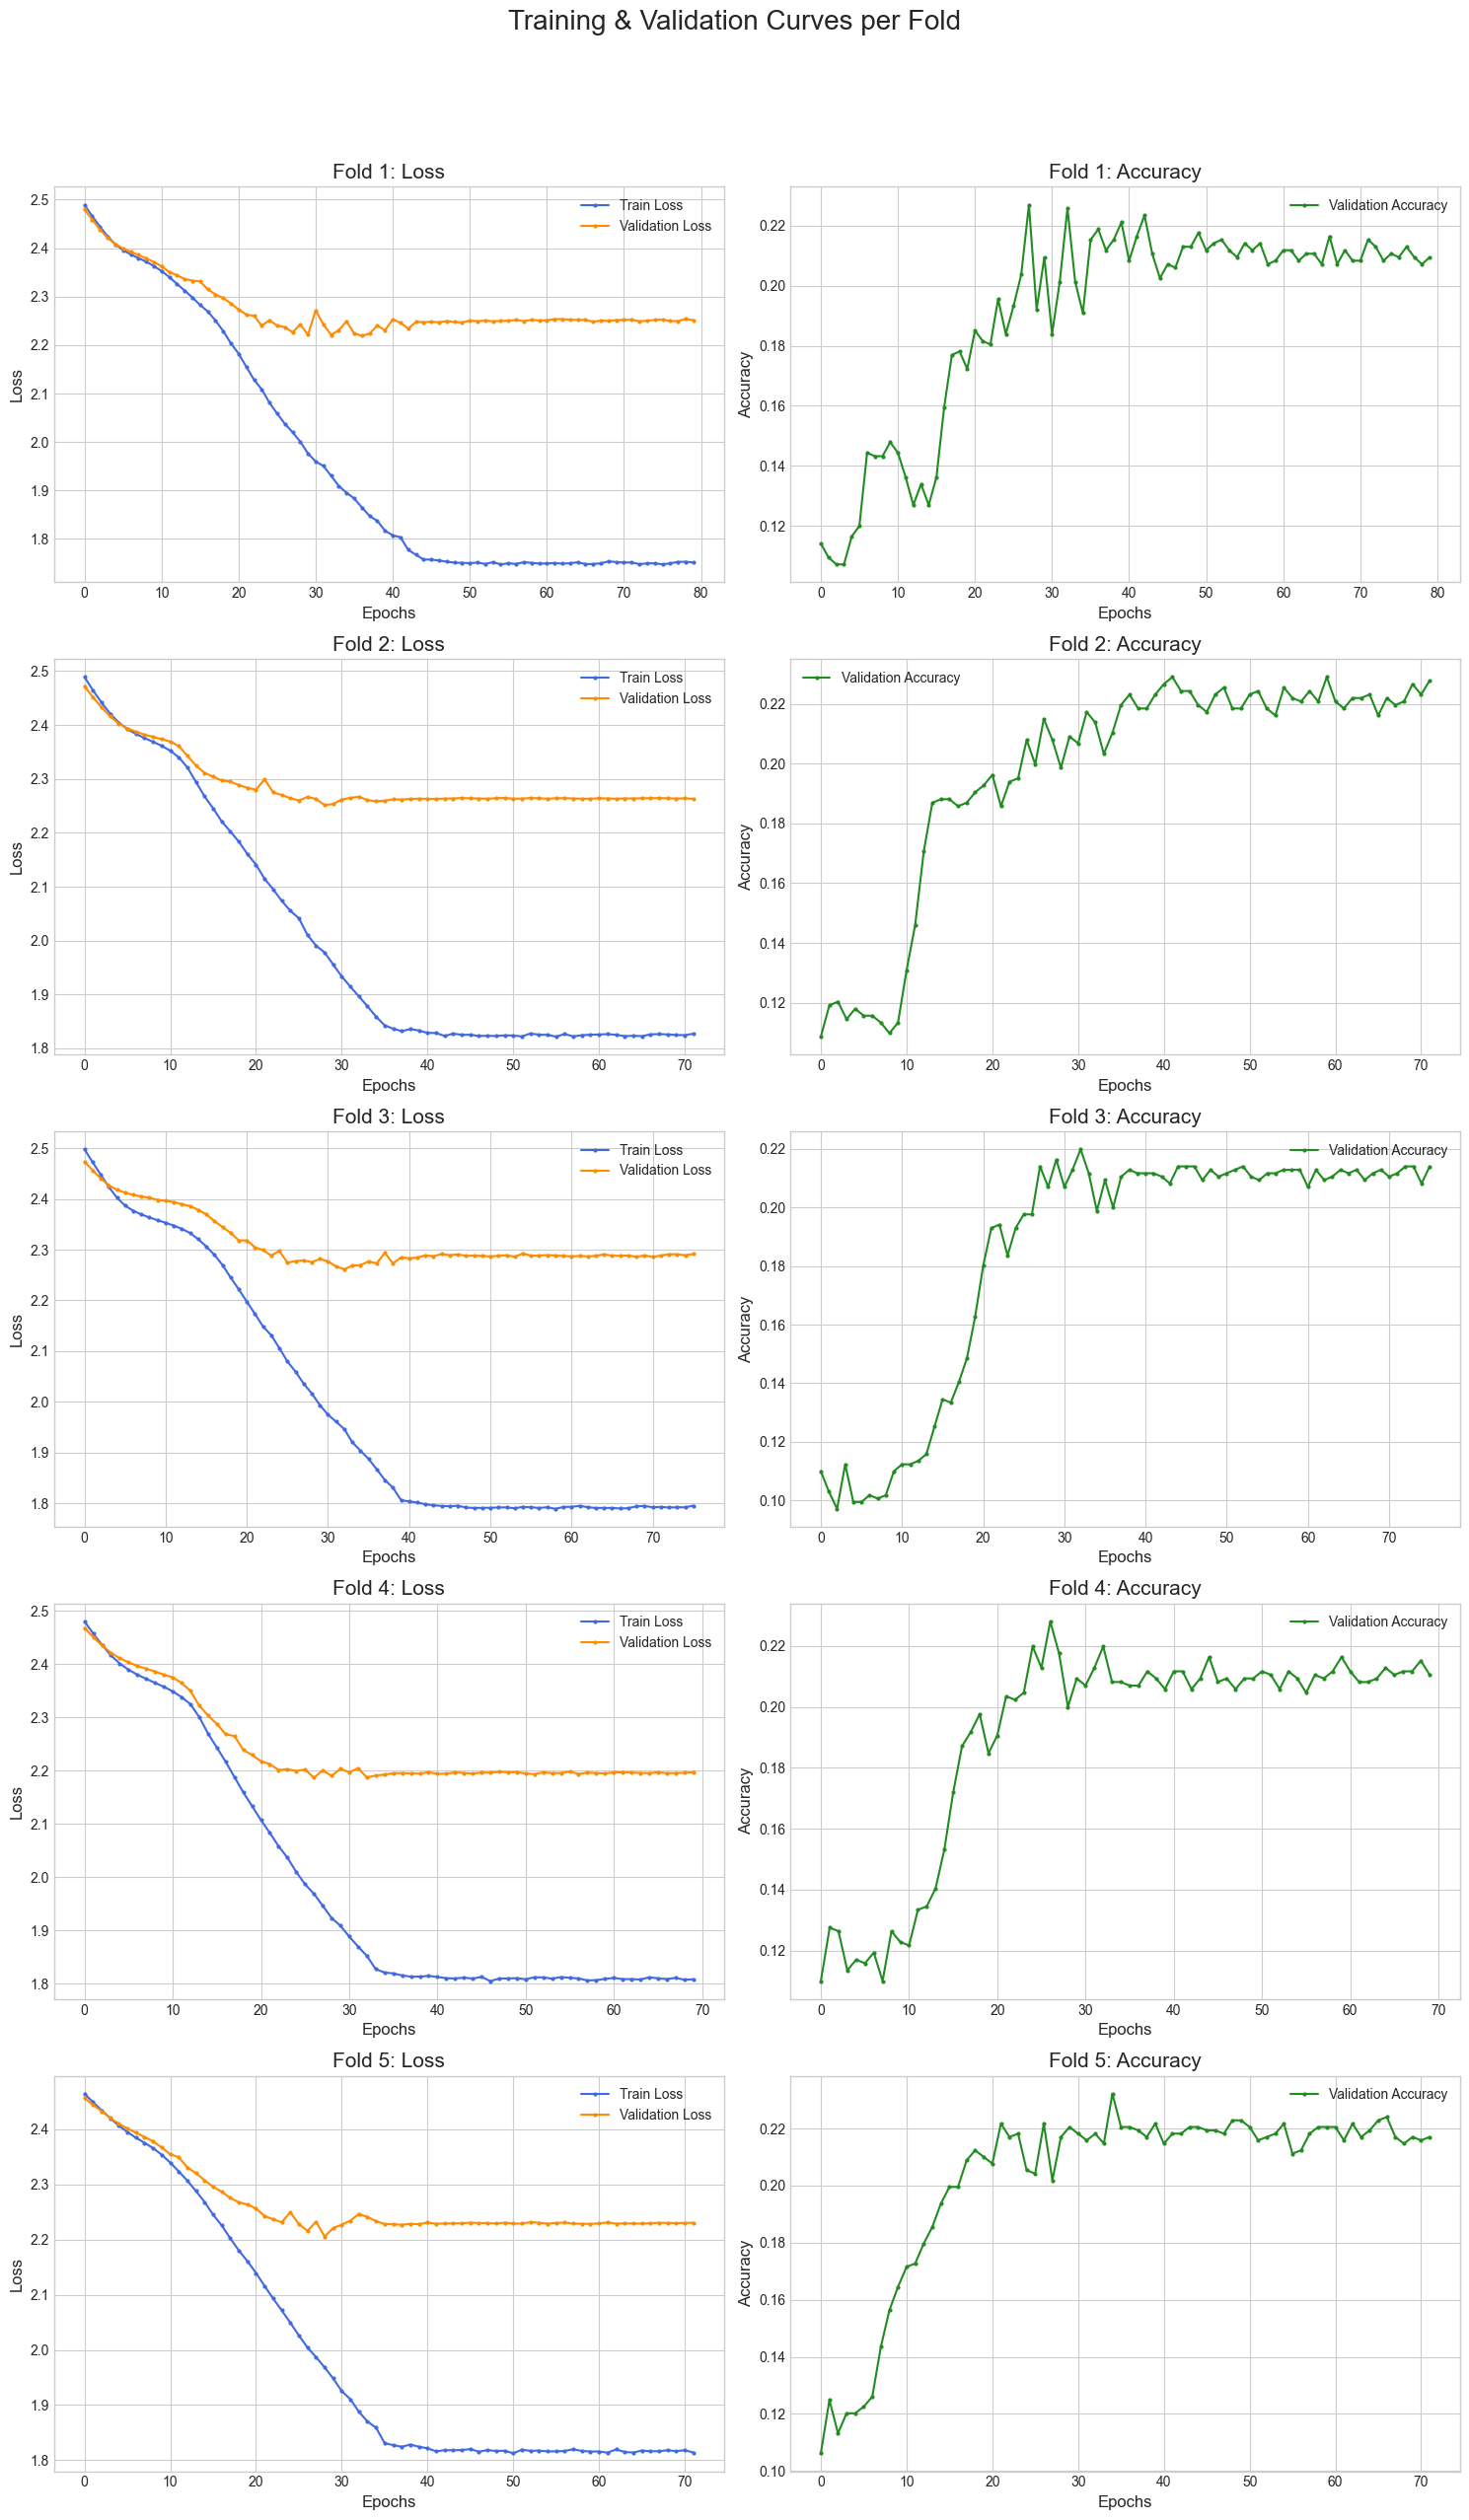

In [66]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(N_SPLITS, 2, figsize=(15, 5 * N_SPLITS))
fig.suptitle('Training & Validation Curves per Fold', fontsize=20, y=1.02)

for i, history in enumerate(cv_histories):
    # Loss 그래프
    ax1 = axes[i, 0]
    ax1.plot(history['train_loss'], label='Train Loss', color='royalblue', marker='o', markersize=2)
    ax1.plot(history['val_loss'], label='Validation Loss', color='darkorange', marker='o', markersize=2)
    ax1.set_title(f'Fold {i+1}: Loss', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()

    # Accuracy 그래프
    ax2 = axes[i, 1]
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='forestgreen', marker='o', markersize=2)
    ax2.set_title(f'Fold {i+1}: Accuracy', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

C:\Users\c\AppData\Local\Temp\ipykernel_23112\3658211361.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=fold_names, y=cv_test_scores, palette='viridis')


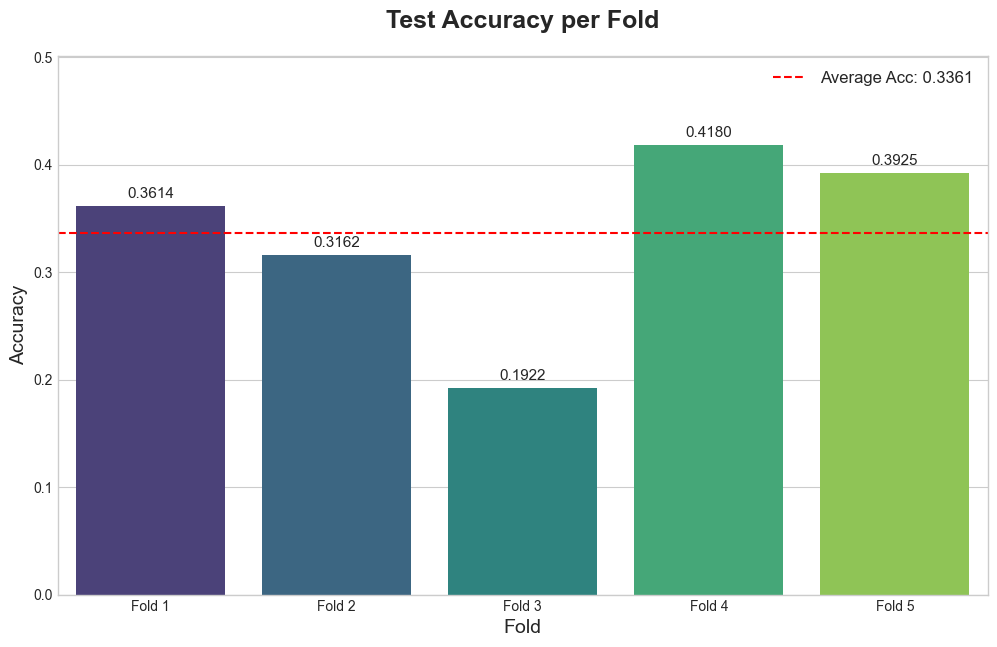

In [67]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

# Fold 이름 리스트 생성
fold_names = [f'Fold {i+1}' for i in range(N_SPLITS)]
average_accuracy = np.mean(cv_test_scores)

# 막대그래프 생성
bar_plot = sns.barplot(x=fold_names, y=cv_test_scores, palette='viridis')

# 그래프 제목 및 라벨 설정
plt.title('Test Accuracy per Fold', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Fold', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, max(cv_test_scores) * 1.2) # y축 범위 설정

# 평균 정확도 선 추가
plt.axhline(y=average_accuracy, color='r', linestyle='--', 
            label=f'Average Acc: {average_accuracy:.4f}')

# 각 막대 위에 정확도 값 표시
for index, value in enumerate(cv_test_scores):
    plt.text(index, value + 0.005, f"{value:.4f}", ha='center', va='bottom', fontsize=11)

plt.legend(fontsize=12)
plt.show()


==================== AGGREGATED CLASSIFICATION REPORT ====================
                               precision    recall  f1-score   support

           L1: Standing still       0.27      0.88      0.41       768
     L2: Sitting and relaxing       0.51      0.29      0.37       766
               L3: Lying down       0.91      1.00      0.95       770
                  L4: Walking       0.32      0.14      0.20       770
          L5: Climbing stairs       0.26      0.04      0.08       763
      L6: Waist bends forward       0.36      0.32      0.34       706
L7: Frontal elevation of arms       0.50      0.13      0.20       735
L8: Knees bending (crouching)       0.71      0.03      0.05       735
                  L9: Cycling       0.49      0.97      0.66       769
                 L10: Jogging       0.49      0.08      0.14       766
                 L11: Running       0.41      1.00      0.59       768
       L12: Jump front & back       0.00      0.00      0.00       257


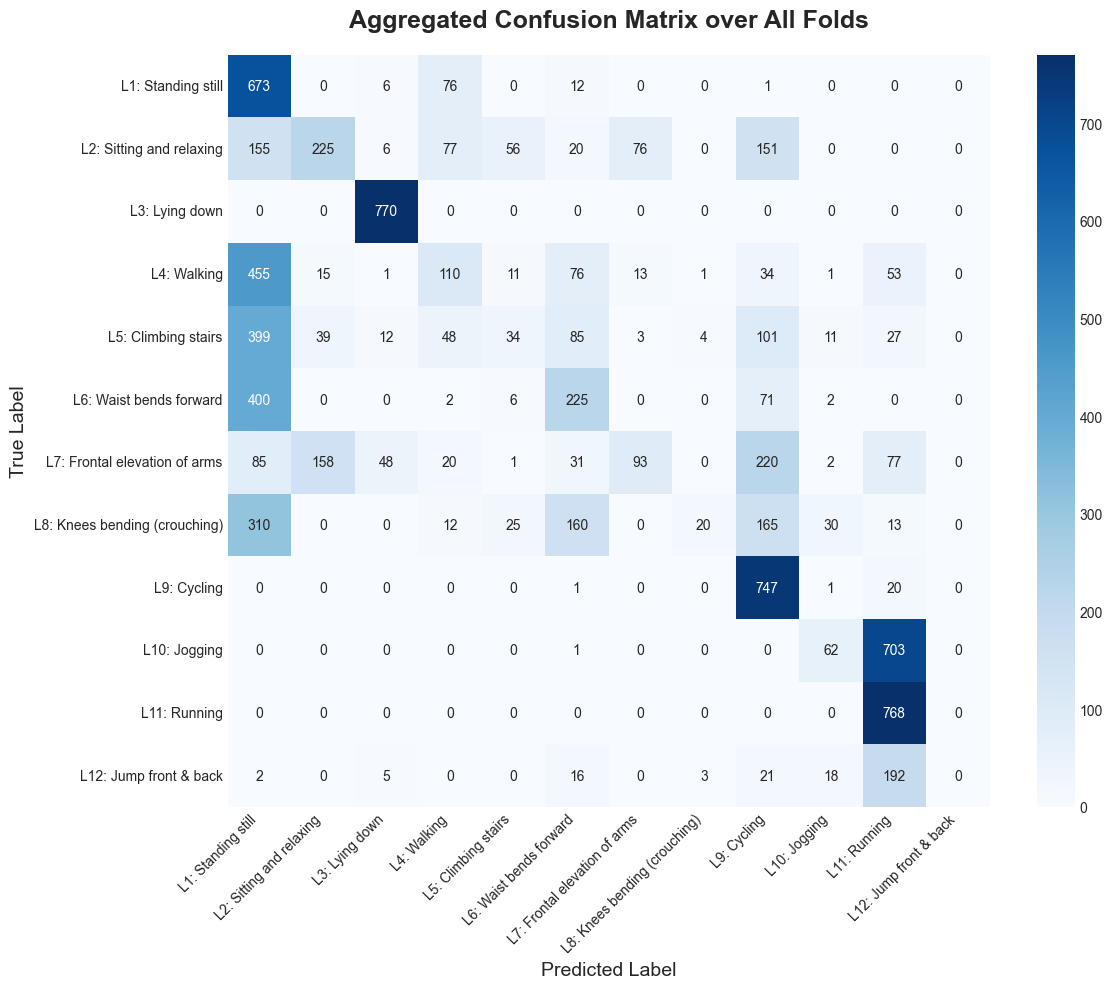

In [135]:
from sklearn.metrics import classification_report, confusion_matrix

# 클래스 이름 정의 (MHEALTH 데이터셋 기준)
class_names = [
    'L1: Standing still', 'L2: Sitting and relaxing', 'L3: Lying down', 
    'L4: Walking', 'L5: Climbing stairs', 'L6: Waist bends forward', 
    'L7: Frontal elevation of arms', 'L8: Knees bending (crouching)', 
    'L9: Cycling', 'L10: Jogging', 'L11: Running', 'L12: Jump front & back'
]
all_possible_labels = list(range(NUM_CLASSES))

# --- Classification Report 출력 ---
print(f"\n{'='*20} AGGREGATED CLASSIFICATION REPORT {'='*20}")
print(classification_report(all_fold_labels, all_fold_preds,
                            target_names=class_names,
                            labels=all_possible_labels,
                            zero_division=0))

# --- Confusion Matrix 시각화 ---
print(f"\n{'='*20} AGGREGATED CONFUSION MATRIX {'='*20}")
cm = confusion_matrix(all_fold_labels, all_fold_preds, labels=all_possible_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Aggregated Confusion Matrix over All Folds', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()